# Engine Performance Decks

In [1]:
# Add path to src/CARPy, in case notebook is running locally
import os, sys, warnings
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\src")))
warnings.simplefilter("ignore")  # <-- Suppress warnings

***
## Introduction

Selecting a suitable engine cycle is a choice that often carries significant weight (sometimes literally!) in the resultant performance of a vehicle concept during a mission.
CARPy allows users to simulate the performance decks of several families and models of engines:

1. BasicPropeller, a collection of non-dimensional propellers including fixed pitch and variable pitch models.
1. BasicTurbo, a collection of non-dimensional turbomachines including turbofans, turbojets, and turboprops.
1. BasicMattingly, a collection of non-dimensional turbomachines including turbofans, turbojets, and turboprops.
1. BasicPiston, a collection of non-dimensional reciprocating engines.
1. BasicElectric, a collection of non-dimensional electric engines.

***
## 1) `BasicPropeller` objects

We start with basic propeller models:

In [2]:
from carpy.propulsion import BasicPropeller

# Collect the names of the classes in the BasicPropeller catalogue
propellers = [attribute for attribute in dir(BasicPropeller) if not attribute.startswith("_")]
print(propellers)

['PropFixPitch', 'PropVarPitch']


`PropFixPitch` refers to fixed pitch (constant speed) propellers, and `PropVarPitch` refers to a more complex propeller design that can vary pitch in flight to maintain the optimal propeller advance ratio, and therefore efficiency `eta_prop`.
In the below code, we look at the difference between fixed and variable pitch propellers.

Computing deck 2/2: Done!                          


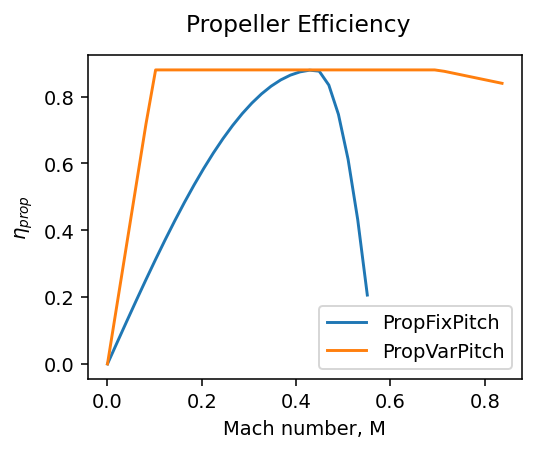

In [3]:
from matplotlib import pyplot as plt
import numpy as np

# Define independent data
Machs = np.linspace(0, 1)
altitudes = np.zeros(Machs.shape)
designspeed = 150  # <-- Designed best flight speed for the fixed pitch propeller

# Spawn a figure
figrows = len(propellers)
fig, ax = plt.subplots(1, dpi=140, figsize=(4, 3))

# Iterate over the defined turbomachine class names
for i, classname in enumerate(propellers):
    
    print(f"\rComputing deck {i+1}/{figrows}: {classname}...", end=" "*16)
    
    # Instantiate relevant engine deck and compute dependent values
    if classname == "PropFixPitch":
        enginedeck = BasicPropeller.PropFixPitch(Vdes=designspeed)
    elif classname == "PropVarPitch":
        enginedeck = getattr(BasicPropeller, classname)()
    else:
        continue  # Skip anything that isn't recognised
    eta_prop = enginedeck.eta_prop(Machs, altitudes)
    
    ax.plot(Machs, eta_prop, label=classname)

else:
    print(f"\rComputing deck {i+1}/{figrows}: Done!"+" "*20)
    
    fig.suptitle("Propeller Efficiency")
    ax.set_xlabel("Mach number, M")
    ax.set_ylabel("$\eta_{prop}$")
    ax.legend()

plt.show()

***
## 2) `BasicTurbo` objects

The `BasicTurbo` object is a catalogue of representative turbomachines for a variety of conventional engine cycles, including:

1. HiBPR, for high-bypass ratio (BPR $\gg$ 1) engines that you'd usually find in pod-style nacelles.
2. LoBPRmixed, for low-bypass ratio (BPR $\sim$1) engines that you'd usually find embedded within the fuselage of military fighter aircraft.
3. LoBPRmixedAB, similar to LoBPRmixed but with afterburner (reheat) engaged.
4. Turbojet, for turbojet engines.
5. TurbojetAB, for turbojet engines with afterburner (reheat) engaged.

In [4]:
from carpy.propulsion import BasicTurbo

# Collect the names of the classes in the BasicTurbo catalogue
turbomachines = [attribute for attribute in dir(BasicTurbo) if not attribute.startswith("_")]
print(turbomachines)

['TurbofanHiBPR', 'TurbofanLoBPRmixed', 'TurbofanLoBPRmixedAB', 'Turbojet', 'TurbojetAB', 'Turboprop']


Let's peek into the decks and compare their relative performance:

Computing deck 6/6: Done!                                  


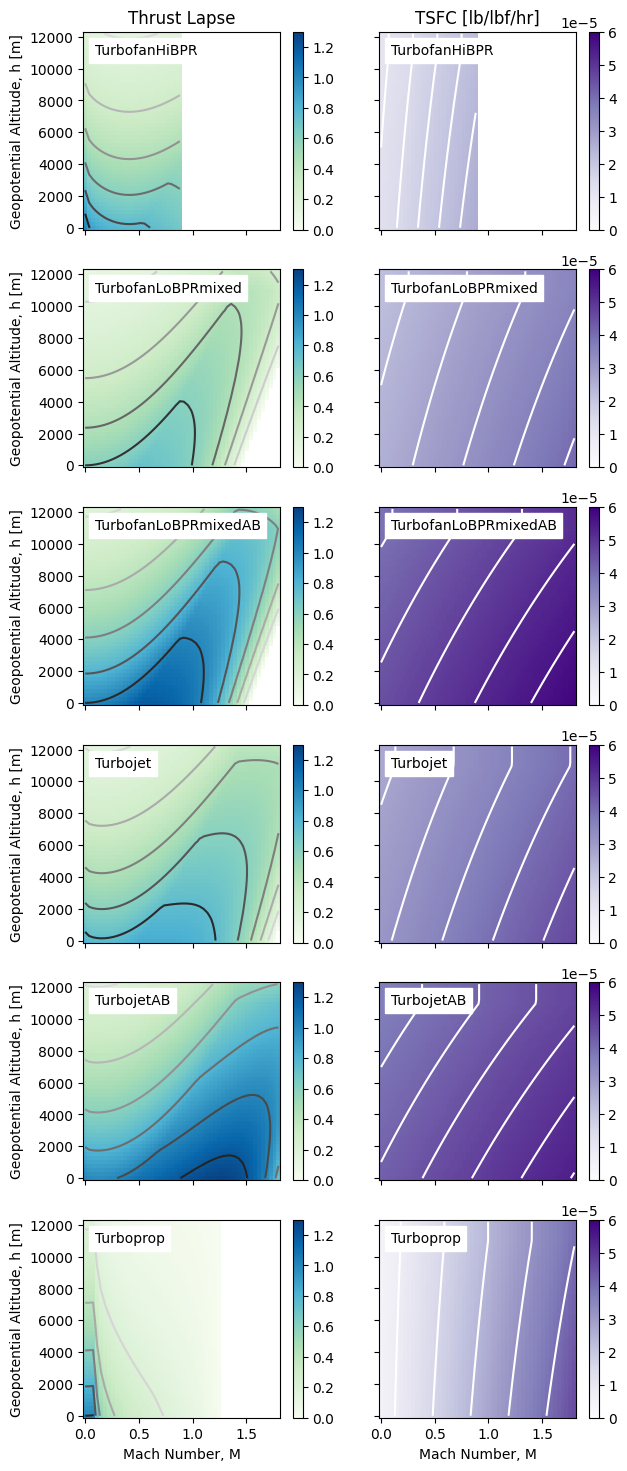

In [5]:
from carpy.utility import Quantity

# Define independent data
Machs = np.linspace(0, 1.8)
altitudes = Quantity(np.linspace(0, 40e3), "ft")
mesh_M, mesh_h = np.meshgrid(Machs, altitudes)

# Spawn a figure
figrows = len(turbomachines)
fig, axs = plt.subplots(figrows, 2, figsize=(7, 3 * figrows), sharex=True, sharey=True)

# Iterate over the defined turbomachine class names
for i, classname in enumerate(turbomachines):
    
    print(f"\rComputing deck {i+1}/{figrows}: {classname}...", end=" "*16)
    
    # Instantiate relevant engine deck and compute dependent values
    enginedeck = getattr(BasicTurbo, classname)()
    Tlapse = enginedeck.Tlapse(mesh_M, mesh_h)
    TSFC = enginedeck.TSFC(mesh_M, mesh_h)
    
    # Plot data
    cm0 = axs[i][0].pcolormesh(mesh_M, mesh_h, Tlapse, vmin=0, vmax=1.3, cmap="GnBu")
    cs0 = axs[i][0].contour(mesh_M, mesh_h, Tlapse, cmap="binary", levels=5)
    cm1 = axs[i][1].pcolormesh(mesh_M, mesh_h, TSFC, vmin=0, vmax=6e-5, cmap="Purples")
    cs1 = axs[i][1].contour(mesh_M, mesh_h, TSFC, colors="white", levels=5)
    
    # Produce colour bars
    fig.colorbar(cm0, ax=axs[i][0])
    fig.colorbar(cm1, ax=axs[i][1])
    
    # Annotate plots
    xtext, ytext = 0.05 * Machs.max(), 0.95 * altitudes.max()
    axs[i][0].text(xtext, ytext, classname, backgroundcolor="white", va="top")
    axs[i][1].text(xtext, ytext, classname, backgroundcolor="white", va="top")
    axs[i][0].set_ylabel("Geopotential Altitude, h [m]")

else:
    print(f"\rComputing deck {i+1}/{figrows}: Done!"+" "*20)
    
    axs[0][0].set_title("Thrust Lapse")
    axs[0][1].set_title("TSFC [lb/lbf/hr]")
    axs[i][0].set_xlabel("Mach Number, M")
    axs[i][1].set_xlabel("Mach Number, M")

plt.show()

Each graph's color bar has been scaled to the same range, and the purpose of contours is to qualitatively indicate the surface gradient.
Afterburning, low-bypass cycles appear the most fuel intensive, with unducted fan/high bypass designs presenting more economical options.
Low-bypass cycles tend to retain the most performance over the widest range of flight conditions.

***
## 3) `BasicMattingly` objects

Many of the decks in the `BasicTurbo` section are actually from Mattingly.
The list of Mattingly-derived decks is as follows:

In [6]:
from carpy.propulsion import BasicMattingly

# Collect the names of the classes in the BasicTurbo catalogue
Mdecks = [attribute for attribute in dir(BasicMattingly) if not attribute.startswith("_")]
print(Mdecks)

['TurbofanHiBPR', 'TurbofanLoBPRmixed', 'TurbofanLoBPRmixedAB', 'Turbojet', 'TurbojetAB', 'Turboprop']


***
## 4) `BasicPiston` objects

The `BasicPiston` object is a catalogue containing various performance lapse methods for piston engines, including:

1. PistonGaggFarrar, a power lapse method based on the Gagg-Farrar model.
1. PistonNACA925, a power lapse method based on findings of NACA report No. 925.

In [7]:
from carpy.propulsion import BasicPiston

# Collect the names of the classes in the BasicPiston catalogue
pistonengines = [attribute for attribute in dir(BasicPiston) if not attribute.startswith("_")]
print(pistonengines)

['PistonGaggFarrar', 'PistonNACA925']


We can compare the effect of atmospheric density lapse on the predicted drop in power as follows

Computing deck 2/6: Done!                              


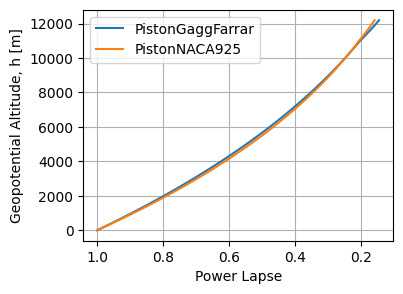

In [8]:
# Define independent data
Machs = np.linspace(0, 1)
altitudes = Quantity(np.linspace(0, 40e3), "ft")

fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True, sharey=True)

# Iterate over the defined piston engine class names
for i, classname in enumerate(pistonengines):
    
    print(f"\rComputing deck {i+1}/{len(pistonengines)}: {classname}...", end=" "*16)
    
    # Instantiate relevant engine deck and compute dependent values
    enginedeck = getattr(BasicPiston, classname)()
    Plapse = enginedeck.Plapse(Machs, altitudes)
    
    ax.plot(Plapse, altitudes, label=classname)
else:
    print(f"\rComputing deck {i+1}/{figrows}: Done!"+" "*20)
    
    ax.set_xlim(ax.get_xlim()[::-1])
    
    ax.set_xlabel("Power Lapse")
    ax.set_ylabel("Geopotential Altitude, h [m]")
    ax.grid()
    ax.legend()

plt.show()

We can use some basic physics principles to convert from a power lapse to thrust lapse, given that a reciprocating engine produces rotational shaft power (and no inherent thrust, neglecting pumping losses).

You may already be familiar with an equation for converting between power and force

$$P=F \times V$$

Consider that the flight power of a propeller is the power of the shaft $P$ multiplied by it's efficiency $\eta_{prop}$, and equal to the thrust developed by a propeller $T$ and the speed of the oncoming freestream air $V$

$$\eta_{prop} \cdot P = T \times V$$

Converting from a power lapse model to a thrust lapse model then requires the comparison of "at altitude" flight conditions, compared to sea-level-static conditions

$$\frac{T}{T_{sls}} = \frac{\eta_{prop} \cdot P}{\eta_{prop,sls} \cdot P_{sls}} \times \frac{V_{sls}}{V}$$

This is problematic in that for a finite amount of power developed in the engine at sea level static $P_{sls}$, both $V_{sls} \doteq 0$ and $\eta_{prop,sls} \doteq 0$, making the thrust lapse undefinable.
CARPy skirts this issue with some numerical trickery, by normalising "at altitude" flight conditions to close to, yet not quite sea level static conditions.

As far as the problem of estimating $\eta_{prop}$, attaching a propeller object to an engine deck object that requires it is as simple as addition: 

In [9]:
powerplant = BasicPiston.PistonGaggFarrar()  # Spawn a powerplant object
propeller = BasicPropeller.PropVarPitch()  # Spawn a propeller object

enginedeck = powerplant + propeller  # Add the two together!

# Evaluate previously inaccessible thrust-based results
print("Thrust lapse of the combination deck at Mach 0.2, sea level:", enginedeck.Tlapse(Mach=0.2, altitude=0))

Thrust lapse of the combination deck at Mach 0.2, sea level: 0.5 


In the background, the propeller object checks that the powerplant evaluates either of `BSFC` or `Plapse` - and if either is true, the propeller object can attach itself and permit evaluation of `TSFC` and `Tlapse`, respectively.
In summary, this quasi-static trick and combination engine deck allows us to evaluate thrust lapse:

Computing deck 4/4: Done!                                                     


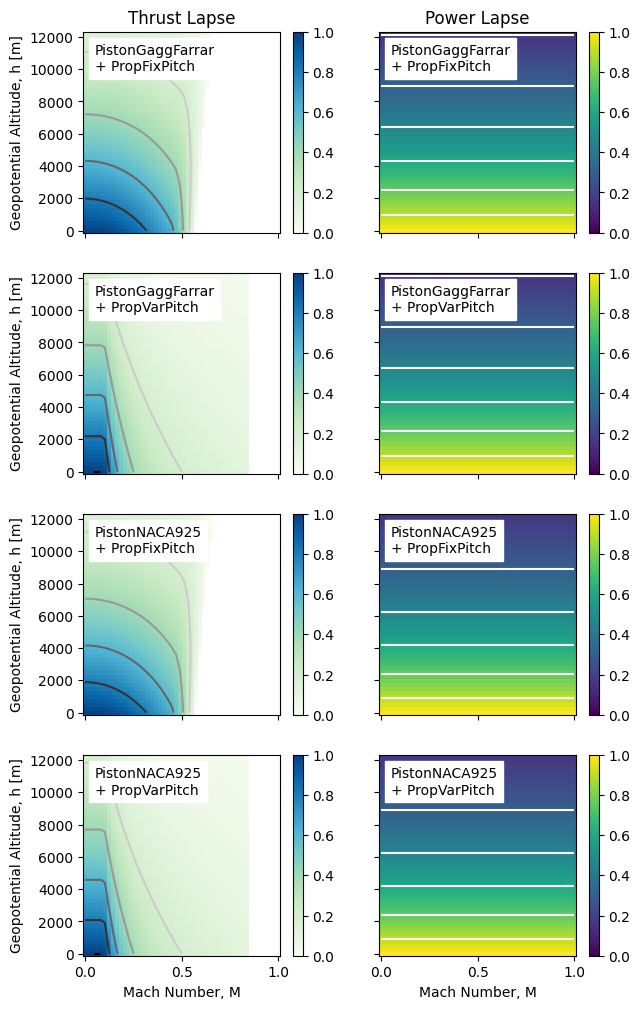

In [10]:
# We'll use itertools to make interesting combinations of piston engine and propeller type
from itertools import product as ip

# Define independent data
Machs = np.linspace(0, 1)
altitudes = Quantity(np.linspace(0, 40e3), "ft")
mesh_M, mesh_h = np.meshgrid(Machs, altitudes)
designspeed = 150  # <-- Designed best flight speed for the fixed pitch propeller

# Spawn a figure
figrows = len(pistonengines) * len(propellers)
fig, axs = plt.subplots(figrows, 2, figsize=(7, 3 * figrows), sharex=True, sharey=True)

# Iterate over the defined piston and propeller class names
for i, (pistonclassname, propclassname) in enumerate(ip(pistonengines, propellers)):
    
    print(f"\rComputing deck {i+1}/{figrows}: {pistonclassname} + {propclassname}...", end=" "*24)
    
    # Instantiate relevant engine deck and compute dependent values
    pistondeck = getattr(BasicPiston, pistonclassname)()
    if propclassname == "PropFixPitch":
        propdeck = BasicPropeller.PropFixPitch(Vdes=designspeed)
    elif propclassname == "PropVarPitch":
        propdeck = getattr(BasicPropeller, propclassname)()
    else:
        continue  # Skip anything that isn't recognised
    enginedeck = pistondeck + propdeck  # <-- The secret sauce that allows you to combine decks!
    
    Tlapse = enginedeck.Tlapse(mesh_M, mesh_h)
    Plapse = enginedeck.Plapse(mesh_M, mesh_h)
    
    # Plot data
    cm0 = axs[i][0].pcolormesh(mesh_M, mesh_h, Tlapse, vmin=0, vmax=1, cmap="GnBu")
    cs0 = axs[i][0].contour(mesh_M, mesh_h, Tlapse, cmap="binary", levels=5)
    cm1 = axs[i][1].pcolormesh(mesh_M, mesh_h, Plapse, vmin=0, vmax=1, cmap="viridis")
    cs1 = axs[i][1].contour(mesh_M, mesh_h, Plapse, colors="white", levels=5)
    
    # Produce colour bars
    fig.colorbar(cm0, ax=axs[i][0])
    fig.colorbar(cm1, ax=axs[i][1])
    
    # Annotate plots
    xtext, ytext = 0.05 * Machs.max(), 0.95 * altitudes.max()
    classname = "\n+ ".join((pistonclassname, propclassname))
    axs[i][0].text(xtext, ytext, classname, backgroundcolor="white", va="top", wrap=True)
    axs[i][1].text(xtext, ytext, classname, backgroundcolor="white", va="top", wrap=True)
    axs[i][0].set_ylabel("Geopotential Altitude, h [m]")

else:
    print(f"\rComputing deck {i+1}/{figrows}: Done!"+" "*30)
    
    axs[0][0].set_title("Thrust Lapse")
    axs[0][1].set_title("Power Lapse")
    axs[i][0].set_xlabel("Mach Number, M")
    axs[i][1].set_xlabel("Mach Number, M")

plt.show()

Note that while it seems the fixed pitch propeller appears more performant over a wider range of conditions than a variable pitch propeller, this is performance relative to _sea level static_ thrust.
To find out why this is important, it is critical to recognise that a fixed pitch propeller's efficiency curve is often maximised near some cruise condition - and therefore poor performance is to be expected due to low efficiency in low-speed regimes.
Variable pitch propellers on the other hand are able to make use of their pitch variability to maintain much greater efficiency in regions that include low-speed phases of flight (such as groundroll and takeoff).
Therefore, the static thrust developed for a variable pitch propeller far exceeds that of a fixed pitch one.

So when it appears that a fixed pitch propeller looks like its doing a better job of producing thrust consistently - it is in fact, better at maintaining a consistent level of thrust.
It just does so at the expense of really poor shaftpower utilisation in low-speed flight.

***
## 5) `BasicElectric` objects

There are also models for electric motors:

In [11]:
from carpy.propulsion import BasicElectric

# Collect the names of the classes in the BasicPiston catalogue
electricengines = [attribute for attribute in dir(BasicElectric) if not attribute.startswith("_")]
print(electricengines)

['ElectricMotor']


Unsurprisingly, a 'basic' electric motor's power output is not a function of airspeed or altitude.
In reality, it will be somewhat related to the ability of the vehicle's thermal mass and cooling systems to dissipate thermal energy from the motor - and is therefore neglected here.

Computing deck 2/2: Done!                                                  


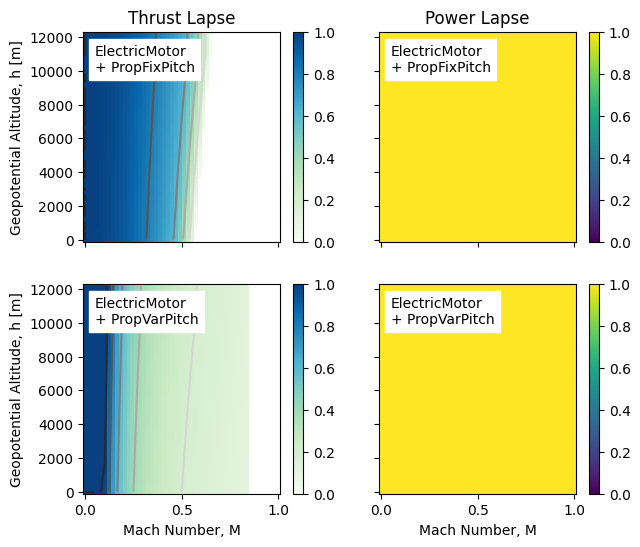

In [12]:
# We'll use itertools to make interesting combinations of electric engine and propeller type
from itertools import product as ip

# Define independent data
Machs = np.linspace(0, 1)
altitudes = Quantity(np.linspace(0, 40e3), "ft")
mesh_M, mesh_h = np.meshgrid(Machs, altitudes)
designspeed = 150  # <-- Designed best flight speed for the fixed pitch propeller

# Spawn a figure
figrows = len(electricengines) * len(propellers)
fig, axs = plt.subplots(figrows, 2, figsize=(7, 3 * figrows), sharex=True, sharey=True)

# Iterate over the defined electric and propeller class names
for i, (electricclassname, propclassname) in enumerate(ip(electricengines, propellers)):
    
    print(f"\rComputing deck {i+1}/{figrows}: {electricclassname} + {propclassname}...", end=" "*24)
    
    # Instantiate relevant engine deck and compute dependent values
    electricdeck = getattr(BasicElectric, electricclassname)()
    if propclassname == "PropFixPitch":
        propdeck = BasicPropeller.PropFixPitch(Vdes=designspeed)
    elif propclassname == "PropVarPitch":
        propdeck = getattr(BasicPropeller, propclassname)()
    else:
        continue  # Skip anything that isn't recognised
    enginedeck = electricdeck + propdeck  # <-- The secret sauce that allows you to combine decks!
    
    Tlapse = enginedeck.Tlapse(mesh_M, mesh_h)
    Plapse = enginedeck.Plapse(mesh_M, mesh_h)
    
    # Plot data
    cm0 = axs[i][0].pcolormesh(mesh_M, mesh_h, Tlapse, vmin=0, vmax=1, cmap="GnBu")
    cs0 = axs[i][0].contour(mesh_M, mesh_h, Tlapse, cmap="binary", levels=5)
    cm1 = axs[i][1].pcolormesh(mesh_M, mesh_h, Plapse, vmin=0, vmax=1, cmap="viridis")
    cs1 = axs[i][1].contour(mesh_M, mesh_h, Plapse, colors="white", levels=5)
    
    # Produce colour bars
    fig.colorbar(cm0, ax=axs[i][0])
    fig.colorbar(cm1, ax=axs[i][1])
    
    # Annotate plots
    xtext, ytext = 0.05 * Machs.max(), 0.95 * altitudes.max()
    classname = "\n+ ".join((electricclassname, propclassname))
    axs[i][0].text(xtext, ytext, classname, backgroundcolor="white", va="top", wrap=True)
    axs[i][1].text(xtext, ytext, classname, backgroundcolor="white", va="top", wrap=True)
    axs[i][0].set_ylabel("Geopotential Altitude, h [m]")

else:
    print(f"\rComputing deck {i+1}/{figrows}: Done!"+" "*30)
    
    axs[0][0].set_title("Thrust Lapse")
    axs[0][1].set_title("Power Lapse")
    axs[i][0].set_xlabel("Mach Number, M")
    axs[i][1].set_xlabel("Mach Number, M")

plt.show()